In [82]:
# preamble. 
import numpy as np # basic vector/matrix math
import matplotlib.pyplot as plt # plotting and illustrations 
import seaborn as sns # advanced plotting and illustrations. 
import pandas as pd # data loading, saving, and general data manipulation. 
import scipy.stats as stats # inter alia, statistical distributions, functions and relevant objects.
import scipy.optimize as optimize 
import torch # ML/AI model's and general optimization 

# needed for this lab 
from sklearn.preprocessing import PowerTransformer
from sklearn.mixture import GaussianMixture

import math as m

# STA 2453 Lab 3 Submission

This lab notebook must be completed in the appropriate time during class and invigilated by the instructor. There are  3 parts in this evaluation, you must add both this notebook, and another generated `.py` file to the PR. 

Once the PR is in place, please tag both me and the TA in it. So in the end you will have two files. 

- `STA2453-Lab-3.ipynb`
- `STA2453-Lab-3.py`

Both of these are needed for a good submission. 







---

## Case Study: The St. Louis Risk Research Project 

---

Was an observational study to assess the affects of parental
psychological disorders on child development. In the preliminary study, 69 families with 2 children were studied. The link to the dataset can be found here: 
`https://utstat.utoronto.ca/~pocucan/st4.csv`

---

This data is collected from a reading scores of 69 famlies with 2 children. 
It contains the following variables:

- `R1` Reading score of child 1

- `V1` Verbal score of child 1

- `R2` Reading score of child 2

- `V2` Verbal score of child 2

---







---

## Part 1 Power Transforms 
---

This part of the evaluation requires you to employ power transforms to transform data from asymmetric to normal. 

Load the `stlouis` dataset in, plot a histogram of the `R1` and `V1` variables, and comment on the shape of them. 

Next, fit a power transform model on the two variables, and plot histograms  of the transformed data for `R1` and `V1`. 

Compare and contrast the before/after histograms for the transformations.


In [83]:
def load_dataset():
    """
        Load shanghai dataset with missing data. 
    """
    
    df = pd.read_csv("./st4.csv").iloc[1:,:]
    df = df.iloc[:,1:5]
    df.columns = ["R1","V1","R2","V2"]
    
    return df 

def density(xi: np.array, pis: np.array, mus: np.array, Ss:np.array):
    """ 
        Calculate log density of a multivariate normal density
    """
    
    p = xi.shape[0]
    leading_constant = (np.pi * 2.0) ** (- p * 0.5)
    
    xm = xi - mus
    xm = np.expand_dims(xm,axis=0)
    Ss_inv = np.linalg.inv(Ss)
    res = (xm.transpose(1,0,2) @ Ss_inv).transpose(1,0,2)
    res = np.exp( ( -0.5 * (res * xm).sum(-1)) )
   
    # result 
    res = pis * np.sqrt(np.linalg.det(Ss_inv)) * res 
    res = float(leading_constant) * res	
    
    return res 



def conditional_mean_imputation(X: np.array, pis: np.array, mus: np.array, Ss: np.array):
    """
        Calculates cmi imputation based on z, mu, sigma, and x, for partials. 
        
        Takes in a vector x (1,p) 
        
    """

    # get missing vector index. 
    
    mis = pd.DataFrame(X).isna().to_numpy() 

    for i in range(X.shape[0]):
        xi = X[i,:] 
        mi = mis[i,:] 
        # get non missing entries
        xi_d = xi[~mi]

        # get parameters. 
        mu_d = mus[:, ~mi]
        mu_m = mus[:, mi] 
        Ss_dd = Ss[:, ~mi][:,:, ~mi]
        Ss_md = Ss[:, mi][:,:,~mi]
        Ss_mm = Ss[:, mi][:,:,mi]

        # compute conditional means. 
        dd_diff = np.expand_dims(xi_d - mu_d,-1)
        
        # leading matrix term. 
        lmatrix_term = Ss_md @ ( np.linalg.inv(Ss_dd))
        mu_tildes = mu_m + (lmatrix_term @ (dd_diff))[:,:,0] 

        zigs = density(xi_d, pis, mu_d, Ss_dd) 
        zigs = zigs / zigs.sum()
        zigs[0,-1] = 1.0 - zigs[0,:-1].sum()
        zigs = zigs.transpose() 
        xi_m_imputed = (mu_tildes * zigs).sum(0)
        xi[mi] = xi_m_imputed 
            

    return X 

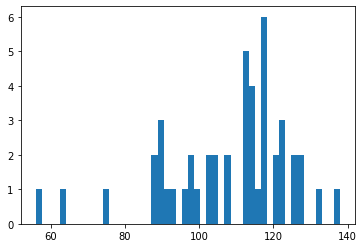

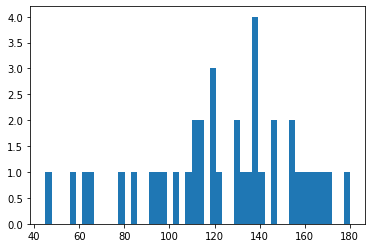

<Figure size 432x288 with 0 Axes>

In [84]:
# load the dataset st4 dataset. 
df = load_dataset()
# plot histograms of the reading and verbal score for child 1. 
plt.hist(df["R1"], bins=50)
plt.show()
plt.hist(df["V1"], bins=50)
plt.show()
plt.clf()

In [85]:
# plot histogram is verbal score of child 1
# Both dataset looks non-noraml and skewed to the left

/Users/moudixin/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


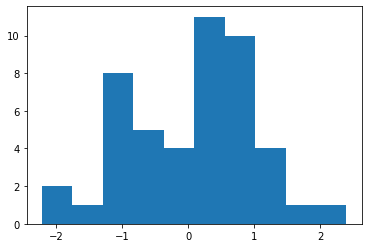

(array([4., 1., 3., 5., 6., 4., 7., 3., 4., 2.]),
 array([-2.04883046, -1.6473846 , -1.24593874, -0.84449289, -0.44304703,
        -0.04160117,  0.35984469,  0.76129055,  1.16273641,  1.56418227,
         1.96562813]),
 <BarContainer object of 10 artists>)

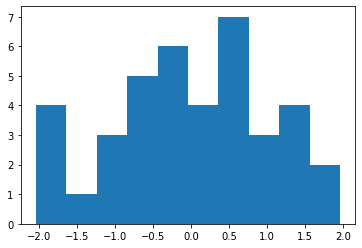

In [86]:
# declare a power transformer 
pt = PowerTransformer()

# fit the power transformer onto the dataset. 
pt.fit(df.to_numpy())

# transform the data, fit into dataframe. 
pt_df = pt.transform(df)
pt_df = pd.DataFrame(pt_df)    

pt_df.columns = df.columns    

# plot histograms. 
plt.hist(pt_df["R1"], bins=10)
plt.show()
plt.hist(pt_df["V1"], bins=10)


In [87]:
# After the powertransformation, the histagram of both variables are much more "Normal"

---
## Part 2 Imputation
---

Take the original data. Perform an imputation procedure using a GMM model as discussed in class. 

Find the optimal number of G via some metric, show your results. 

Plot a pairsplot with the following schematic: 
- grey points are fully complete datapoints. 
- blue points are imputed datapoints and overlayed with the original grey. 

Comment on the fits and any relationships. 


In [88]:

# segment the relevant data for said power transformer
na_mask = df.isna().any(axis=1) 
df_na = df.loc[na_mask,:]

# remove fully missing observations 
df_na = df_na.loc[~df_na.isna().all(axis=1),:].copy() 

# clean 
df_clean = df.loc[~na_mask,:]

In [89]:
lowest_bic = m.inf
best_G = -1

for i in range(1,15):
    temp = GaussianMixture(n_components=i)
    temp.fit(df_clean.to_numpy())
    bic = temp.bic(df_clean.to_numpy())

    if lowest_bic > bic:
        lowest_bic = bic
        best_G = i
    print(f"BIC with G={i} is {bic}")
    
print(f"G with Lowest BIC is {best_G}")

BIC with G=1 is 943.8633265736285
BIC with G=2 is 973.2064083927759
BIC with G=3 is 997.8105925014779
BIC with G=4 is 990.2936015322786
BIC with G=5 is 920.5373773379829
BIC with G=6 is 884.8663011056092
BIC with G=7 is 848.4186788945703
BIC with G=8 is 682.1586208260373
BIC with G=9 is 705.9093736756195
BIC with G=10 is 586.6592401692312
BIC with G=11 is 454.20033517326056
BIC with G=12 is 378.7326274369896
BIC with G=13 is 163.00598772322655
BIC with G=14 is 238.6331625458729
G with Lowest BIC is 13


In [90]:
# fit best model 
G = best_G
mm = GaussianMixture(n_components=G)
mm.fit(df_clean.to_numpy())

# get parameters for imputation 
mus = mm.means_
Ss = mm.covariances_
pis = mm.weights_

# impute dataset
x_imputed_numpy = conditional_mean_imputation(np.copy(df_na.to_numpy()), pis, mus, Ss);
df_imputed = pd.DataFrame(x_imputed_numpy)

df_imputed.columns = df_clean.columns    

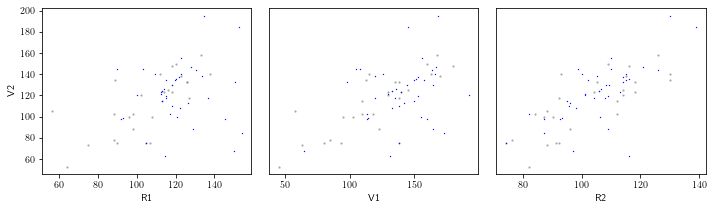

In [91]:
# plot results. 
plt.rcParams['text.usetex'] = True


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
marker_size = 5.0
alpha = 0.70

marker_color = "grey"

ax1.set_title('')
sns.scatterplot(x='R1', y='V2', data=df_clean, ax=ax1, alpha=alpha, s=marker_size, color=marker_color)
ax1.set_xlabel(r"R1")
ax1.set_ylabel(r"V2")

ax2.set_title('')
sns.scatterplot(x='V1', y='V2', data=df_clean, ax=ax2, s=marker_size, alpha=alpha, color=marker_color)
ax2.set_xlabel(r"V1")
ax2.set_ylabel("")
ax2.axes.get_yaxis().set_visible(False)


ax3.set_title('')
sns.scatterplot(x='R2', y='V2', data=df_clean, ax=ax3, s=marker_size, alpha=alpha, color=marker_color)
ax3.set_xlabel(r"R2")
ax3.set_ylabel("")
ax3.axes.get_yaxis().set_visible(False)
fig.tight_layout()

marker_size = 1.7 
alpha = 1.0

#color_palatte = sns.color_palette("cubehelix",7)
color_palatte = sns.color_palette("magma", 20)
colors = "blue" #df.labels.apply(lambda label: color_palatte[0])
edge_color = "lightblue"# colors

sns.scatterplot(x='R1', y='V2', data=df_imputed, ax=ax1, alpha=alpha, s=marker_size, edgecolor=edge_color, color=colors)
sns.scatterplot(x='V1', y='V2', data=df_imputed, ax=ax2, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)
sns.scatterplot(x='R2', y='V2', data=df_imputed, ax=ax3, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)

plt.show()
plt.clf()
plt.rcParams['text.usetex'] = False
plt.close()

---
## Part 3 Transformation and Imputation 
---

Take the original data. Perform an imputation procedure using a mixture model `AND` a transformation procedure together. 

To achieve a level 3 you must incorporate the transformation coherently, and, fit a mixture model after for imputation purposes. Here, the transformation, and fitting of the mixture model is done `SEPARATELY`. Ensure that during the imputation step you are working in the Gaussian space, and then transform it appropriately to desired domain of the original data. You are free to use any transformation scheme you like, Power transforms, Manly, etc. 

To achieve a level 4 you must adequatly incorporate a transformation `DIRECTLY` within the density of the mixture model component definition, and, fit it appropriately within an estimation step. It is reasonable to assume that if your component-wise distribution is already Gaussian, than your transformation method will still work, just won't be doing much.  

Find the optimal number of G via some metric, show your results. 

Plot a pairsplot with the following schematic: 
- grey points are fully complete datapoints. 
- red points are imputed datapoints and overlayed with the original grey. 

Comment on the impuation and any relationships within the data, compare and contrast the results of the red points vs the blue points from Part 2. 


In [92]:
df = pt_df
# get na mask 
na_mask = df.isna().any(axis=1) 
df_na = df.loc[na_mask,:]

# remove fully missing observations 
df_na = df_na.loc[~df_na.isna().all(axis=1),:].copy() 

# clean 
df_clean = df.loc[~na_mask,:]

In [93]:
lowest_bic = m.inf
best_G = -1

for i in range(1,15):
    temp = GaussianMixture(n_components=i)
    temp.fit(df_clean.to_numpy())
    bic = temp.bic(df_clean.to_numpy())

    if lowest_bic > bic:
        lowest_bic = bic
        best_G = i
    print(f"BIC with G={i} is {bic}")
    
print(f"G with Lowest BIC is {best_G}")

BIC with G=1 is 279.5419348495794
BIC with G=2 is 309.91031373039147
BIC with G=3 is 277.1347322340491
BIC with G=4 is 281.96045783101033
BIC with G=5 is 240.6907650140092
BIC with G=6 is 279.86047305512545
BIC with G=7 is 250.0178548059863
BIC with G=8 is 156.31513927349943
BIC with G=9 is 210.78183160108486
BIC with G=10 is 137.1385889684663
BIC with G=11 is 83.68594635323024
BIC with G=12 is 59.441538670712816
BIC with G=13 is 30.81115677025457
BIC with G=14 is 31.068697465499554
G with Lowest BIC is 13


In [94]:
# fit best model 
G = best_G
mm = GaussianMixture(n_components=G)
mm.fit(df_clean.to_numpy())

# get parameters for imputation 
mus = mm.means_
Ss = mm.covariances_
pis = mm.weights_

# impute dataset
x_imputed_numpy = conditional_mean_imputation(np.copy(pt_df.to_numpy()), pis, mus, Ss);
df_imputed = pd.DataFrame(x_imputed_numpy)

df_imputed.columns = df_clean.columns  
df_imputed

/var/folders/qm/x5j5dd_j69x0dqj16b3sjqdw0000gn/T/ipykernel_12707/814212766.py:67: RuntimeWarning: invalid value encountered in divide
  zigs = zigs / zigs.sum()


,R1,V1,R2,V2
0,0.553171,1.378923,-5.343901,0.503857
1,0.399276,0.645879,0.629458,0.337159
2,1.755878,1.394153,1.415200,1.305206
3,0.553171,0.471702,0.892765,0.270076
4,2.375327,-0.187155,0.031558,0.767709
...,...,...,...,...
63,1.402803,0.190803,1.089317,0.632870
64,1.553759,-0.187155,0.231727,0.101318
65,1.709474,0.309005,-0.304088,0.833146
66,-0.357570,0.403073,-2.096460,-1.425063


In [95]:
df_imputed = pd.DataFrame(pt.inverse_transform(df_imputed))
df_imputed.columns = df.columns

df_clean = pd.DataFrame(pt.inverse_transform(df_clean))
df_clean.columns = df.columns


/Users/moudixin/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
/Users/moudixin/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(


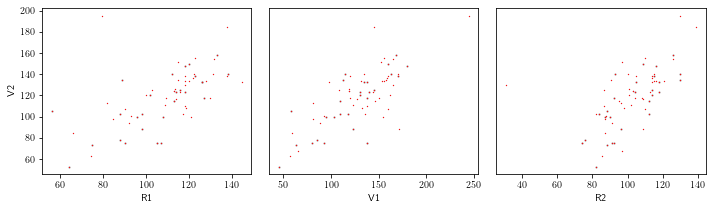

In [101]:
# plot results. 
plt.rcParams['text.usetex'] = True


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
marker_size = 5.0
alpha = 0.70

marker_color = "grey"

ax1.set_title('')
sns.scatterplot(x='R1', y='V2', data=df_clean, ax=ax1, alpha=alpha, s=marker_size, color=marker_color)
ax1.set_xlabel(r"R1")
ax1.set_ylabel(r"V2")

ax2.set_title('')
sns.scatterplot(x='V1', y='V2', data=df_clean, ax=ax2, s=marker_size, alpha=alpha, color=marker_color)
ax2.set_xlabel(r"V1")
ax2.set_ylabel("")
ax2.axes.get_yaxis().set_visible(False)


ax3.set_title('')
sns.scatterplot(x='R2', y='V2', data=df_clean, ax=ax3, s=marker_size, alpha=alpha, color=marker_color)
ax3.set_xlabel(r"R2")
ax3.set_ylabel("")
ax3.axes.get_yaxis().set_visible(False)
fig.tight_layout()

marker_size = 1.7 
alpha = 1.0

#color_palatte = sns.color_palette("cubehelix",7)
color_palatte = sns.color_palette("magma", 20)
colors = "red" #df.labels.apply(lambda label: color_palatte[0])
edge_color = "lightblue"# colors

sns.scatterplot(x='R1', y='V2', data=df_imputed, ax=ax1, alpha=alpha, s=marker_size, edgecolor=edge_color, color=colors)
sns.scatterplot(x='V1', y='V2', data=df_imputed, ax=ax2, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)
sns.scatterplot(x='R2', y='V2', data=df_imputed, ax=ax3, s=marker_size, alpha=alpha, color=colors, edgecolor=edge_color)

plt.show()
plt.clf()
plt.rcParams['text.usetex'] = False
plt.close()

In [97]:
# based on this approach, the tails are captured much better, data is imputed clearly. 